# Global Corona Virus Dashboard
#### made with Bokeh
-------------

# Tables of Content:

**1. [Introduction](#Introduction)** <br>
    Info's about datasets
    
**2. [Librarys](#Libraries)** <br>
    Importing Libraries
    
**3. [Importing Data/Data Cleaning/Feature Engineering](#Cleaning)** <br>
    Importing the data directly from github, clening it and creating new features.
    
**4. [Saving Cleaned Data](#save)** <br>
    Saving the clean version of the data to be used for the dashboard
    
**5. [Extras](#extra)** <br>
	Some other visualizations
    
--------------
--------------
--------------

<a id="Introduction"></a> <br>
# 1. Introduction:

The data for this visualization is gotten from [John Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series).

The data is a time series data that is updated daily based on new cases reported. The data is in 3 different csv:

1. [Confirmed Cases Globally](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)

2. [Recovered Cases Globally](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)

3. [Death Cases Globally](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)

The number of rows in the data varies but the data contained the following columns after I merged the 3 data together:

- Country: The country of the recorded value
- Lat: Latitude of the country
- Long: Longitude of the country
- Date: Date of the day the values were recorded
- confirmed_cases: Number of cummulative confirmed cases for the particular country
- death_cases: Number of cummulative death for the particular country
- recovered_cases: Number of cummulative recovered cases for the particular country

After a little data cleaning, the following columns were added
- confirm: formated version of confirmed_cases
- recovered: formated version of recovered_cases
- death: formated version of death_cases

**The formating done was to add ',' in appropriate places, so 12345 was formated to 12,345**

------
------

<a id="Libraries"></a> <br>
# 2. Libraries: 
- Importing Librarys

In [1]:
#Importing necessary libraries

import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import wordcloud
import seaborn as sns

from sklearn.preprocessing import StandardScaler

<a id="Cleaning"></a> <br>
# 3. Importing Data/Data Cleaning/Feature Engineering:
- Reading the data directly from [John Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)
- Feature Cleaning
- Feat Engineering

In [2]:
#Url to the John Hopkins DataSet for number of confirmed cases
url1 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

#Url to the John Hopkins DataSet for number of death cases
url2 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#Url to the John Hopkins DataSet for number of recovered cases
url3 = 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

#Using the get  request to get the HTML code for the site
data1 =requests.get(url1)

data2 =requests.get(url2)

data3 =requests.get(url3)

#Formatting the HTML using Beautiful Soup
soupcon = BeautifulSoup(data1.content,'html.parser')

soupdeath = BeautifulSoup(data2.content,'html.parser')

souprec = BeautifulSoup(data3.content,'html.parser')

#Printing the formatted HTML
#print(soupdeath.prettify())

def scrape(i, value):
    #Using the find_all function to find all table in the url
    covid = i.find_all('table', class_ = ["js-csv-data csv-data js-file-line-container"])[0]
    
    #Getting the table header, which usually have the 'th' attributes
    headers = [header.text for header in covid.find_all('th')]

    # I realize that the header for the index of the table doesn't have the 'td' attribute instead if 'th'
    # So i will be creating a new header that will have enough length to match the data lenght
    mole = headers.copy()
    mole.append('a')

    # Getting the entries for each row in the data
    rows = []
    
    for row in covid.find_all('tr'):
        rows.append([val.text for val in row.find_all('td')])
    
    # Converting our scraped data into a dataframe
    data = pd.DataFrame(rows, columns=mole)

    # Correcting the column names
    data = data.drop(columns='Province/State')
    data.columns = headers
    
    import numpy as np
    #dropping rows that has missing values all through
    data.dropna(axis=0, how='all', inplace=True)
    
    #replacing special characters with appropriate value
    data.columns = data.columns.str.replace("\n", "")    
    data.replace(["\b"], [""], regex=True, inplace=True)
    data.replace([","], [""], regex=True, inplace=True)
    data.replace(r"\b[a-zA-Z]''\b", np.nan, regex=True, inplace=True)
    data = data.apply(pd.to_numeric, errors='ignore')
    
    #Since not all countries contains Province/State, we are grouping to get the sum of all entries from countrie whose
    #were stored  province/State wise
    data = data.groupby(by=['Country/Region']).sum()
    
    #Resetting the index
    data = data.reset_index()
    
    #Melting the data so that the date column names might be a column on its own
    data = data.melt(id_vars=['Country/Region', 'Lat', 'Long'],var_name="Date", value_name=value)
    
    #creating a function to convert the date column to an appropriate format
    def correctd(a):
        '''Correcting some errors in the date column'''
        a = a.split('/')
        a[-1] = str(2020)
        a = '/'.join(a)
        return a
    
    from datetime import datetime
            
    data['Date']=data['Date'].apply(correctd)
    data['Date'] = pd.to_datetime(data['Date'], format="%m/%d/%Y")
    return data

confirmed_cases = scrape(soupcon, 'confirmed_cases')

death_cases = scrape(soupdeath, 'death_cases')

recovered_cases = scrape(souprec, 'recovered_cases')

#Joining the three datasets together

df = confirmed_cases.merge(death_cases, how='inner', on=['Date', 'Country/Region', 'Lat', 'Long'])

df = df.merge(recovered_cases, how='inner', on=['Date', 'Country/Region', 'Lat', 'Long'])

df.columns = ['Country', 'Lat', 'Long', 'Date', 'confirmed_cases', 'death_cases', 'recovered_cases']

def cleaner(i):
    '''this function simply strips texts of trailing white spaces 
    and takes only the country'''
    i = i.split('(')
    i = i[0]
    i = i.strip()
    return i

df['Country'] = df['Country'].apply(cleaner)

def formater(a):
    '''Converts python numbers to numbers with delimeter in right places. So 12345 becomes 12,345'''
    a = int(a)
    return format(a, ',d')

df['Date'] = pd.to_datetime(df['Date'])

df['confirm'] = df['confirmed_cases'].apply(formater)

df['recovered'] = df['recovered_cases'].apply(formater)

df['death'] = df['death_cases'].apply(formater)

print('done')

done


In [3]:
# Scaling the death column so as to accomodate the large variance of data in a plot
scaler = StandardScaler(copy=False)

df['death1'] = scaler.fit_transform(np.array(df['death_cases']).reshape(-1, 1)) + 1

df['death1'] = df['death1']*2

df = df.sort_values(by = 'Date')

In [4]:
df.tail()

,Country,Lat,Long,Date,confirmed_cases,death_cases,recovered_cases,confirm,recovered,death,death1
39986,Finland,61.924110,25.748151,2020-09-20,8980,339,7700,"8,980","7,700",339,1.715181
39987,France,91.397395,60.040886,2020-09-20,467614,31257,93586,"467,614","93,586","31,257",7.262811
39988,Gabon,-0.803700,11.609400,2020-09-20,8696,53,7848,"8,696","7,848",53,1.663864
39990,Georgia,42.315400,43.356900,2020-09-20,3502,19,1494,"3,502","1,494",19,1.657764
40094,Zimbabwe,-19.015438,29.154857,2020-09-20,7683,225,5924,"7,683","5,924",225,1.694726


In [5]:
#Manually correcting name of countries that were spelled wrongly

df_replace = {'Taiwan*':'Taiwan', "Cote d'Ivoire":"Côte d'Ivoire",'Czechia':'Czech Republic', 
              'US':'United States of America', 'Korea South':'South Korea'}

df['Country'] = df['Country'].replace(df_replace)

In [6]:
# Creating a copy of the data, just to reduce the dimentionality of the data and also,
# the data are to be used for different plots on the dashboard.

df_copy = df.copy() #Creating a copy of the initial data

def world(df):
    '''Creates a new entry which will be the global cases as an entry.'''
    temp_dict = {}
    date = df['Date'].value_counts().index
    date = list(date)
    for i in date:
        a = df[df['Date']==i]
        temp_dict = a['confirmed_cases death_cases recovered_cases'.split()].sum()
        temp_dict['Date'] = i
        temp_dict['Country/Region'] = 'Global'
        temp_dict['confirm'] = formater(temp_dict['confirmed_cases'])
        temp_dict['recovered'] = formater(temp_dict['recovered_cases'])
        temp_dict['death'] = formater(temp_dict['death_cases'])
        df.loc[df.index.max() + 1] = temp_dict

world(df_copy) #Applying the above function

country = df_copy['Country'].value_counts().index

for i in country:
#finding the daily reported cases from the cummulative    
    a = df_copy[df_copy['Country']==i]
    daily_conf = a['confirmed_cases'].diff()
    daily_death = a['death_cases'].diff()
    daily_recovered = a['recovered_cases'].diff()
    df_copy.loc[daily_conf.index,'daily_conf'] = daily_conf.values
    df_copy.loc[daily_death.index,'daily_death'] = daily_death.values
    df_copy.loc[daily_recovered.index,'daily_recovered'] = daily_recovered.values
    
df_copy.dropna(inplace=True)
df_copy['daily_conf_f'] = df_copy['daily_conf'].apply(formater)

df_copy['daily_recovered_f'] = df_copy['daily_recovered'].apply(formater)

df_copy['daily_death_f'] = df_copy['daily_death'].apply(formater)

In [7]:
df.head()

,Country,Lat,Long,Date,confirmed_cases,death_cases,recovered_cases,confirm,recovered,death,death1
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,0,0,1.654354
106,Namibia,-22.95760,18.490400,2020-01-22,0,0,0,0,0,0,1.654354
107,Nepal,28.16670,84.250000,2020-01-22,0,0,0,0,0,0,1.654354
108,Netherlands,107.04420,-264.960300,2020-01-22,0,0,0,0,0,0,1.654354
109,New Zealand,-40.90060,174.886000,2020-01-22,0,0,0,0,0,0,1.654354


In [8]:
# Importing a data on continent. This is to be used to map countries to their continent./

continent = pd.read_csv('Data/countryContinent.csv', skipinitialspace=True, encoding = "ISO-8859-1")

In [9]:
continent['continent'].value_counts()

Africa      58
Americas    55
Europe      51
Asia        51
Oceania     25
Name: continent, dtype: int64

In [10]:
continent.head()

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0


In [11]:
continent_dict = {} #Creating an empty dict for easy mapping

# a for loop to fill up the empty dictionary with countries and their respective continent for easy mapping

for country in continent['country']:
    cont = continent[continent['country']==country]['continent']
    c = cont.values[0]
    continent_dict[country] = c

In [12]:
# Noting to drop all entries for 'Diamond Princess','MS Zaandam' because they are names of ships
drop =  'Diamond Princess','MS Zaandam'

# Manually assigning some countries to their continent
update = {'Venezuela':'Americas', 'West Bank and Gaza':'Asia', 'Vietnam':'Asia', 'Burma':'Asia',
          'North Macedonia': 'Europe', 'Kosovo':'Europe','Bolivia':'Americas', 'Taiwan':'Asia',
          'Iran':'Asia', 'Tanzania':'Africa', 'Eswatini':'Africa', 'Russia':'Europe', 'Brunei':'Asia',
          'Syria':'Asia', 'Moldova':'Europe', 'United Kingdom':'Europe', 'Laos':'Asia', 'South Korea':'Asia'}

In [13]:
continent_dict.update(update)

In [14]:
#adding an extra column named continent to our data, 'df'
df['continent'] = df['Country'].replace(continent_dict)
print(df['continent'].value_counts())

Africa              11907
Europe               9963
Asia                 8748
Americas             8019
Oceania               972
Diamond Princess      243
MS Zaandam            243
Name: continent, dtype: int64


MS Zaandam and Diamond Princess are names of ships, so I will be dropping them.

In [15]:
df.drop(index=df[df['continent']=='Diamond Princess'].index, inplace=True)

df.drop(index=df[df['continent']=='MS Zaandam'].index, inplace=True)

In [16]:
palet = ['cyan','red','orange','navy', 'green']
valu = list(df['continent'].value_counts().index)
color_dict = {}
for index, value in zip(valu,palet):
        color_dict[index] = value

df['color'] = df['continent'].copy()
df['color'] = df['color'].replace(color_dict)
df.head()

,Country,Lat,Long,Date,confirmed_cases,death_cases,recovered_cases,confirm,recovered,death,death1,continent,color
0,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,0,0,1.654354,Asia,orange
106,Namibia,-22.95760,18.490400,2020-01-22,0,0,0,0,0,0,1.654354,Africa,cyan
107,Nepal,28.16670,84.250000,2020-01-22,0,0,0,0,0,0,1.654354,Asia,orange
108,Netherlands,107.04420,-264.960300,2020-01-22,0,0,0,0,0,0,1.654354,Europe,red
109,New Zealand,-40.90060,174.886000,2020-01-22,0,0,0,0,0,0,1.654354,Oceania,green


<a id="save"></a> <br>
# Saving Cleaned Data

In [17]:
df_copy.to_csv('data/imp_line_covid.csv')

In [18]:
df.to_csv('data/github_cool_covid.csv')

<a id="extra"></a> <br>
# Extras

In [19]:
africa = df[df['continent']=='Africa']
africa_conf = africa['confirmed_cases'].sum()

In [20]:
continent = df.groupby('continent').sum()
continent.drop(columns=['Lat', 'Long', 'death1'], inplace = True)

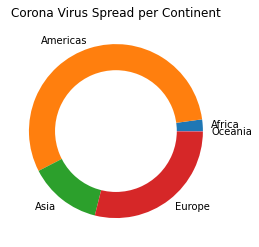

In [21]:
plt.title('Corona Virus Spread per Continent')
plt.pie(continent['death_cases'], labels=continent.index);
plt.pie(x=[1], colors='w', radius=0.7);

In [22]:
country = df.groupby('Country').sum()

def calculate_frequencies(chat_history):
    # Here is a list of punctuations and uninteresting words you can use to process your text
    #wordcloud
    word_dict = {}
    cloud = wordcloud.WordCloud(width=800, height=400, scale=9, max_words=200, 
                                stopwords=wordcloud.STOPWORDS, background_color='white', font_step=1, 
                                colormap='viridis', min_word_length=4)
    cloud.generate_from_frequencies(word_dict)
    return cloud.to_array()

In [23]:
conf_dict = {}
count = list(country.index)
for i in count:
    a = country.loc[[i]]['confirmed_cases']
    a = a[i]
    conf_dict[i] = a

In [24]:
corona = np.array(Image.open("Data/corona1.png"))
corona

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [25]:
cloud = wordcloud.WordCloud(max_words=200, stopwords=wordcloud.STOPWORDS, mask=corona, background_color='black', font_step=1, 
                                contour_width=3, contour_color='white', colormap='gray', min_word_length=4)
cloud.generate_from_frequencies(conf_dict)
image = cloud.to_array()

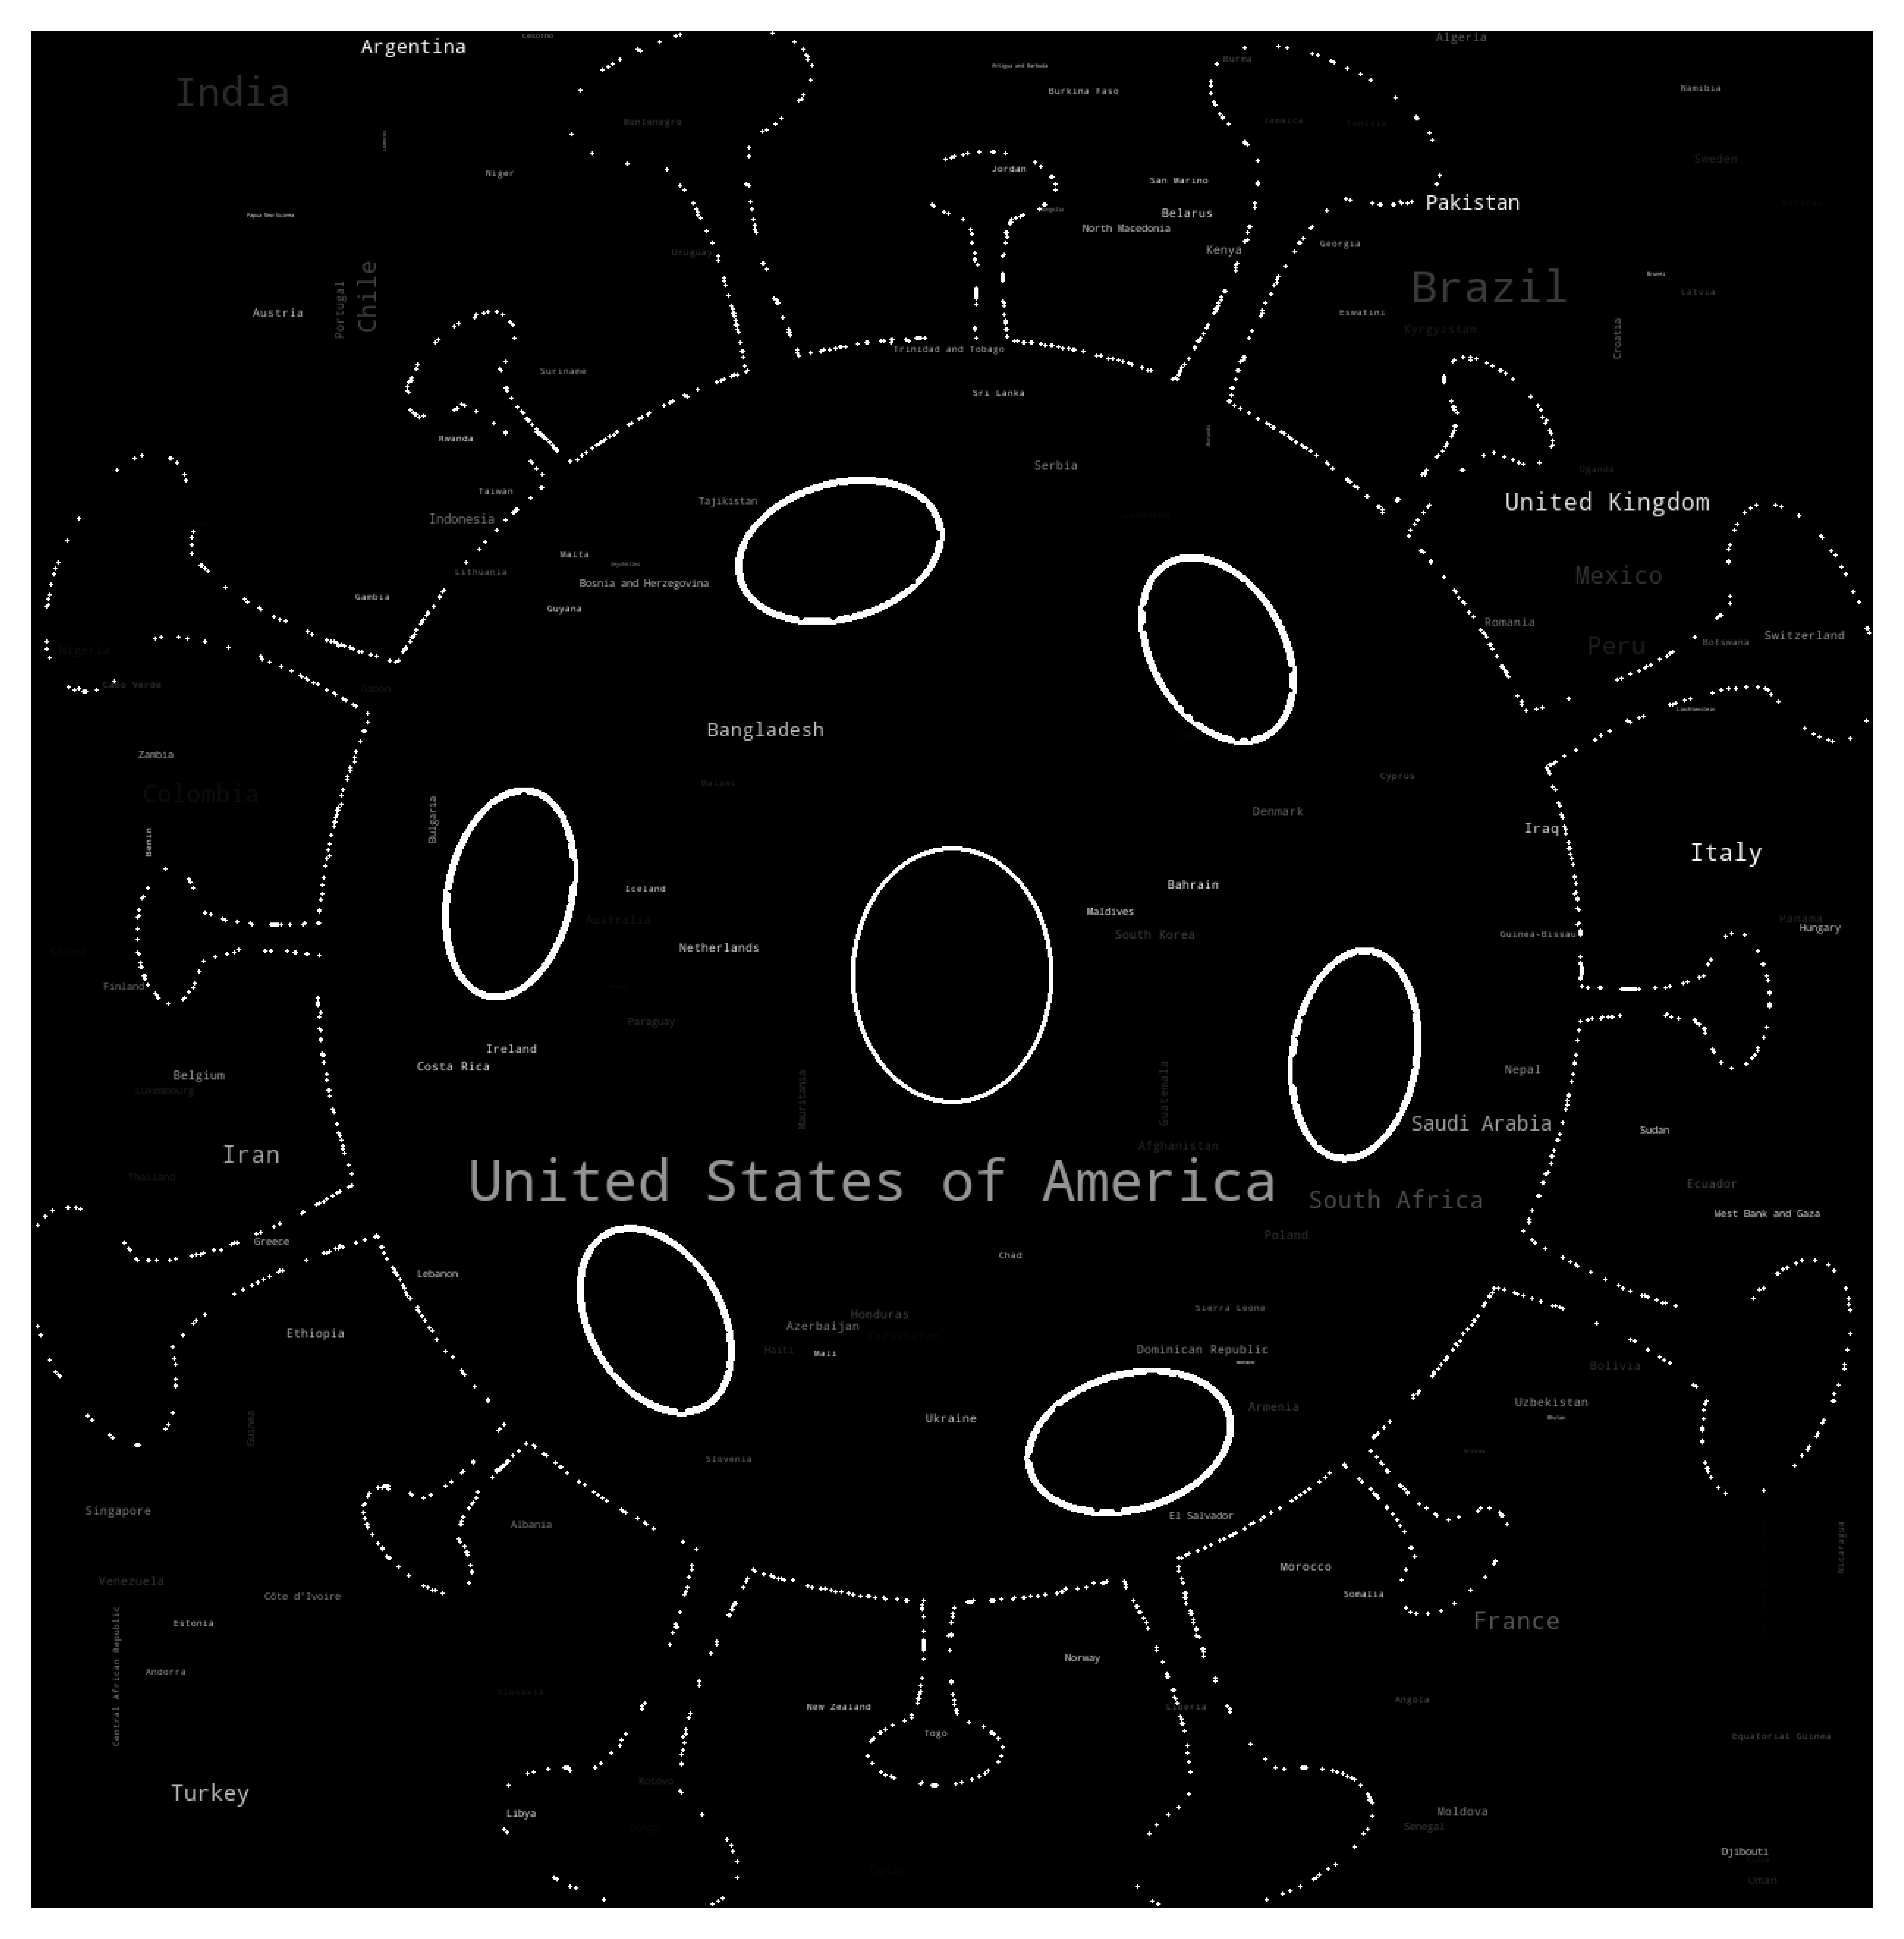

<Figure size 432x288 with 0 Axes>

In [26]:
# Display your wordcloud image

plt.figure(figsize=(10,6), dpi=1000)
plt.imshow(image, interpolation = 'nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

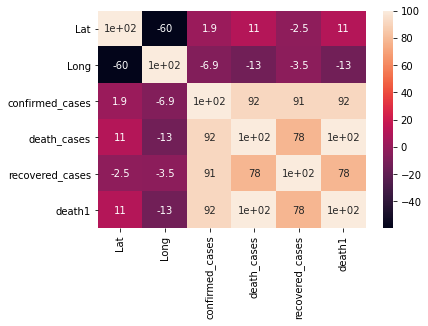

In [27]:
sns.heatmap(df.corr()*100, annot=True)

# To be continued in the app.py file